In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 6 of the nanoCOP manuscript.

This script requires as input datasets created in the script nanoCOP_intron_pairs_datasets.ipynb
                                            

"""

In [99]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math
from random import shuffle
from scipy import stats

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")

In [100]:
def get_all_multi_introns(read_junctions, intron_min):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)
                    
                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                            temp.append(intron_splice)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)
                                

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','gene','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df



def get_splicing_pattern_counts(multi_introns_df, total):
    
    gene_list = []
    splice_status_list = []
    read_info = multi_introns_df[['read','gene','strand']]
    multi_introns_df = multi_introns_df.drop(['read','gene','strand'], 1)

    for i in range(0, len(multi_introns_df)):

        itrons_per_read = sum(multi_introns_df.iloc[i]!='_')
        gene = read_info['gene'][i]

        for j in range(0, itrons_per_read-(total-1)):

            splice_status = multi_introns_df.iloc[i][j:j+total]
            splice_status_str = splice_status.str.cat(sep='_')

            gene_list.append([splice_status_str,gene]) # add gene name to count total genes later 
            splice_status_list.append(splice_status_str)

    pattern_gene_df = pd.DataFrame(gene_list)
    pattern_gene_df.columns = ['pattern', 'gene']

    splice_status_counts = Counter(splice_status_list)
    splicing_patterns_df = pd.DataFrame.from_dict(splice_status_counts, orient='index').reset_index()
    splicing_patterns_df.columns = ['pattern','counts']

    return splicing_patterns_df, pattern_gene_df



def get_intron_splicing_percent(splicing_patterns, int_total):

    introns_1yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 1].reset_index(drop=True)
    introns_1yes['percent'] = introns_1yes['counts'].astype(float)/float(np.sum(introns_1yes['counts']))*100

    introns_2yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 2].reset_index(drop=True)
    introns_2yes['percent'] = introns_2yes['counts'].astype(float)/float(np.sum(introns_2yes['counts']))*100

    if (int_total==3):
        return introns_1yes, introns_2yes
    
    if (int_total==4):
        introns_3yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 3].reset_index(drop=True)
        introns_3yes['percent'] = introns_3yes['counts'].astype(float)/float(np.sum(introns_3yes['counts']))*100

        return introns_1yes, introns_2yes, introns_3yes



In [101]:
# open dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy',encoding='latin1').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy',encoding='latin1').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy',encoding='latin1').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy',encoding='latin1').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy',encoding='latin1').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy',encoding='latin1').item() 

S2_1a_splice_dictionary = np.load('/path/to/S2_1a_splicing_dictionary.npy',encoding='latin1').item() 
S2_1b_splice_dictionary = np.load('/path/to/S2_1b_splicing_dictionary.npy',encoding='latin1').item() 
S2_2_splice_dictionary = np.load('/path/to/S2_2_splicing_dictionary.npy',encoding='latin1').item() 
S2_3_splice_dictionary = np.load('/path/to/S2_3_splicing_dictionary.npy',encoding='latin1').item() 


In [102]:
# get multi intron df for K562
K562_1_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3)
K562_2_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3)
K562_3_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3)
K562_4_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3)
K562_5a_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3)
K562_5b_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3)


In [103]:
# get multi intron df for S2
S2_1a_multi_introns_df = get_all_multi_introns(S2_1a_splice_dictionary, 3)
S2_1b_multi_introns_df = get_all_multi_introns(S2_1b_splice_dictionary, 3)
S2_2_multi_introns_df = get_all_multi_introns(S2_2_splice_dictionary, 3)
S2_3_multi_introns_df = get_all_multi_introns(S2_3_splice_dictionary, 3)


In [104]:
S2_1_multi_introns_df = pd.concat([S2_1a_multi_introns_df, S2_1b_multi_introns_df]).reset_index(drop=True)
S2_1_3introns_splicing_patterns, S2_1_pattern_gene_df = get_splicing_pattern_counts(S2_1_multi_introns_df, 3)
S2_2_3introns_splicing_patterns, S2_2_pattern_gene_df = get_splicing_pattern_counts(S2_2_multi_introns_df, 3)
S2_3_3introns_splicing_patterns, S2_3_pattern_gene_df = get_splicing_pattern_counts(S2_3_multi_introns_df, 3)

S2_1_3introns_splicing_patterns['rep'] = 'S2_1'
S2_2_3introns_splicing_patterns['rep'] = 'S2_2'
S2_3_3introns_splicing_patterns['rep'] = 'S2_3'

S2_3introns_splicing_patterns = pd.concat([S2_1_3introns_splicing_patterns, S2_2_3introns_splicing_patterns, S2_3_3introns_splicing_patterns]).reset_index(drop=True)

S2_pattern_gene = pd.concat([S2_1_pattern_gene_df,S2_2_pattern_gene_df,S2_3_pattern_gene_df]).reset_index(drop=True)
S2_pattern_gene = S2_pattern_gene[S2_pattern_gene['pattern']!="NO_NO_NO"].reset_index(drop=True)
S2_pattern_gene = S2_pattern_gene[S2_pattern_gene['pattern']!="YES_YES_YES"].reset_index(drop=True)
S2_gene_N = S2_pattern_gene['gene'].nunique()
print("S2 # of genes with reads spanning 3 introns: "+str(S2_gene_N))


S2 # of genes with reads spanning 3 introns: 1209


In [105]:
S2_1_introns_1yes, S2_1_introns_2yes = get_intron_splicing_percent(S2_1_3introns_splicing_patterns, 3)
S2_2_introns_1yes, S2_2_introns_2yes = get_intron_splicing_percent(S2_2_3introns_splicing_patterns, 3)
S2_3_introns_1yes, S2_3_introns_2yes = get_intron_splicing_percent(S2_3_3introns_splicing_patterns, 3)

S2_introns_1yes = pd.concat([S2_1_introns_1yes, S2_2_introns_1yes, S2_3_introns_1yes])
S2_introns_2yes = pd.concat([S2_1_introns_2yes, S2_2_introns_2yes, S2_3_introns_2yes])


In [107]:
np.sum(S2_introns_1yes['counts'])+np.sum(S2_introns_2yes['counts'])


2829

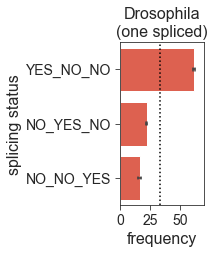

In [12]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO','NO_YES_NO','NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Drosophila\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6A_S2_splicing_order_3int_oneSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [109]:
introns_1yes = S2_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns, 1 spliced, in order p-value: "+str(p))


S2 3 introns, 1 spliced, in order p-value: 5.902657437446698e-94


In [110]:
introns_1yes = S2_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO','NO_YES_NO','NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("S2, 1 intron "+i+" p-value: "+str(p))
    

S2, 1 intron YES_NO_NO p-value: 5.902657437446698e-94
S2, 1 intron NO_YES_NO p-value: 1.1643577343353442e-18
S2, 1 intron NO_NO_YES p-value: 2.050225159650711e-42


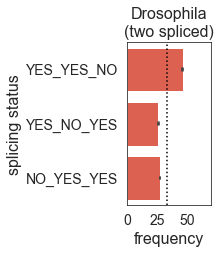

In [15]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO','YES_NO_YES','NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Drosophila\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6A_S2_splicing_order_3int_twoSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [111]:
introns_2yes = S2_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns, 2 spliced, in order p-value: "+str(p))


S2 3 introns, 2 spliced, in order p-value: 8.682148920685012e-27


In [112]:
introns_2yes = S2_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO','YES_NO_YES','NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("S2, 2 spliced, "+i+" p-value: "+str(p))
    

S2, 2 spliced, YES_YES_NO p-value: 8.682148920685012e-27
S2, 2 spliced, YES_NO_YES p-value: 5.04184123382391e-10
S2, 2 spliced, NO_YES_YES p-value: 7.316125656959255e-07


In [56]:
# estimating the statistical probability that introns are spliced in order

in_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']=='YES_NO_NO')]['counts'])+sum(S2_introns_2yes[(S2_introns_2yes['pattern']=='YES_YES_NO')]['counts']) 
no_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']!='YES_NO_NO')]['counts'])+sum(S2_introns_2yes[(S2_introns_2yes['pattern']!='YES_YES_NO')]['counts']) 

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("S2 3 introns spliced in order p-value: "+str(p))


S2 3 introns spliced in order p-value: 1.5712009483751916e-104


In [113]:
#K562
K562_5_multi_introns_df = pd.concat([K562_5a_multi_introns_df, K562_5b_multi_introns_df]).reset_index(drop=True)
K562_1_3introns_splicing_patterns, K562_1_pattern_gene_df = get_splicing_pattern_counts(K562_1_multi_introns_df, 3)
K562_2_3introns_splicing_patterns, K562_2_pattern_gene_df = get_splicing_pattern_counts(K562_2_multi_introns_df, 3)
K562_3_3introns_splicing_patterns, K562_3_pattern_gene_df = get_splicing_pattern_counts(K562_3_multi_introns_df, 3)
K562_4_3introns_splicing_patterns, K562_4_pattern_gene_df = get_splicing_pattern_counts(K562_4_multi_introns_df, 3)
K562_5_3introns_splicing_patterns, K562_5_pattern_gene_df = get_splicing_pattern_counts(K562_5_multi_introns_df, 3)

K562_1_3introns_splicing_patterns['rep'] = 'K562_1'
K562_2_3introns_splicing_patterns['rep'] = 'K562_2'
K562_3_3introns_splicing_patterns['rep'] = 'K562_3'
K562_4_3introns_splicing_patterns['rep'] = 'K562_4'
K562_5_3introns_splicing_patterns['rep'] = 'K562_5'

K562_3introns_splicing_patterns = pd.concat([K562_1_3introns_splicing_patterns, K562_2_3introns_splicing_patterns, K562_3_3introns_splicing_patterns, K562_4_3introns_splicing_patterns, K562_5_3introns_splicing_patterns]).reset_index(drop=True)

K562_pattern_gene = pd.concat([K562_1_pattern_gene_df,K562_2_pattern_gene_df,K562_3_pattern_gene_df,K562_5_pattern_gene_df,K562_4_pattern_gene_df]).reset_index(drop=True)
K562_pattern_gene = K562_pattern_gene[K562_pattern_gene['pattern']!="NO_NO_NO"].reset_index(drop=True)
K562_pattern_gene = K562_pattern_gene[K562_pattern_gene['pattern']!="YES_YES_YES"].reset_index(drop=True)
K562_gene_N = K562_pattern_gene['gene'].nunique()
print("K562 # of genes with reads spanning 3 introns: "+str(K562_gene_N))


K562 # of genes with reads spanning 3 introns: 1221


In [114]:
K562_1_introns_1yes, K562_1_introns_2yes = get_intron_splicing_percent(K562_1_3introns_splicing_patterns, 3)
K562_2_introns_1yes, K562_2_introns_2yes = get_intron_splicing_percent(K562_2_3introns_splicing_patterns, 3)
K562_3_introns_1yes, K562_3_introns_2yes = get_intron_splicing_percent(K562_3_3introns_splicing_patterns, 3)
K562_4_introns_1yes, K562_4_introns_2yes = get_intron_splicing_percent(K562_4_3introns_splicing_patterns, 3)
K562_5_introns_1yes, K562_5_introns_2yes = get_intron_splicing_percent(K562_5_3introns_splicing_patterns, 3)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])


In [116]:
np.sum(K562_introns_1yes['counts'])+np.sum(K562_introns_2yes['counts'])


4116

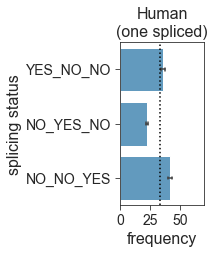

In [42]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO','NO_YES_NO','NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Human\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6A_K562_splicing_order_3int_oneSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [117]:
introns_1yes = K562_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("K562 3 introns, 1 spliced, in order p-value: "+str(p))


K562 3 introns, 1 spliced, in order p-value: 6.10382857919513e-05


In [118]:
introns_1yes = K562_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO','NO_YES_NO','NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("K562, 1 intron "+i+" p-value: "+str(p))
    

K562, 1 intron YES_NO_NO p-value: 6.10382857919513e-05
K562, 1 intron NO_YES_NO p-value: 3.392238295506594e-28
K562, 1 intron NO_NO_YES p-value: 8.274258885740034e-11


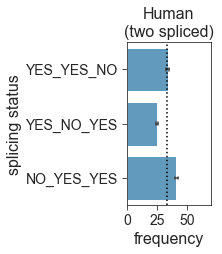

In [44]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO','YES_NO_YES','NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("Human\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6A_K562_splicing_order_3int_twoSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [119]:
introns_2yes = K562_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("K562 3 introns, 2 spliced, in order p-value: "+str(p))


K562 3 introns, 2 spliced, in order p-value: 0.3953212390871441


In [120]:
introns_2yes = K562_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO','YES_NO_YES','NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.3333333333))

    print("K562, 2 spliced, "+i+" p-value: "+str(p))
    

K562, 2 spliced, YES_YES_NO p-value: 0.3953212390871441
K562, 2 spliced, YES_NO_YES p-value: 3.1619451991563086e-15
K562, 2 spliced, NO_YES_YES p-value: 1.5539432794961237e-11


In [121]:
# estimating the statistical probability that introns are spliced in order

in_order = sum(K562_introns_1yes[(K562_introns_1yes['pattern']=='YES_NO_NO')]['counts'])+sum(K562_introns_2yes[(K562_introns_2yes['pattern']=='YES_YES_NO')]['counts']) 
no_order = sum(K562_introns_1yes[(K562_introns_1yes['pattern']!='YES_NO_NO')]['counts'])+sum(K562_introns_2yes[(K562_introns_2yes['pattern']!='YES_YES_NO')]['counts']) 

p = stats.binom_test([in_order,no_order], n=None, p=0.3333333333)
print("K562 3 introns spliced in order p-value: "+str(p))


K562 3 introns spliced in order p-value: 0.0005152332501842168


In [122]:
S2_1_multi_introns_df = pd.concat([S2_1a_multi_introns_df, S2_1b_multi_introns_df]).reset_index(drop=True)
S2_1_4introns_splicing_patterns, S2_1_pattern_gene_df = get_splicing_pattern_counts(S2_1_multi_introns_df, 4)
S2_2_4introns_splicing_patterns, S2_2_pattern_gene_df = get_splicing_pattern_counts(S2_2_multi_introns_df, 4)
S2_3_4introns_splicing_patterns, S2_3_pattern_gene_df = get_splicing_pattern_counts(S2_3_multi_introns_df, 4)

S2_1_4introns_splicing_patterns['rep'] = 'S2_1'
S2_2_4introns_splicing_patterns['rep'] = 'S2_2'
S2_3_4introns_splicing_patterns['rep'] = 'S2_3'

S2_4introns_splicing_patterns = pd.concat([S2_1_4introns_splicing_patterns, S2_2_4introns_splicing_patterns, S2_3_4introns_splicing_patterns])

S2_pattern_gene = pd.concat([S2_1_pattern_gene_df,S2_2_pattern_gene_df,S2_3_pattern_gene_df]).reset_index(drop=True)
S2_pattern_gene = S2_pattern_gene[S2_pattern_gene['pattern']!="NO_NO_NO_NO"].reset_index(drop=True)
S2_pattern_gene = S2_pattern_gene[S2_pattern_gene['pattern']!="YES_YES_YES_YES"].reset_index(drop=True)
S2_gene_N = S2_pattern_gene['gene'].nunique()
print("S2 # of genes with reads spanning 4 introns: "+str(S2_gene_N))


S2 # of genes with reads spanning 4 introns: 565


In [123]:
S2_1_introns_1yes, S2_1_introns_2yes, S2_1_introns_3yes = get_intron_splicing_percent(S2_1_4introns_splicing_patterns, 4)
S2_2_introns_1yes, S2_2_introns_2yes, S2_2_introns_3yes = get_intron_splicing_percent(S2_2_4introns_splicing_patterns, 4)
S2_3_introns_1yes, S2_3_introns_2yes, S2_3_introns_3yes = get_intron_splicing_percent(S2_3_4introns_splicing_patterns, 4)

S2_introns_1yes = pd.concat([S2_1_introns_1yes, S2_2_introns_1yes, S2_3_introns_1yes])
S2_introns_2yes = pd.concat([S2_1_introns_2yes, S2_2_introns_2yes, S2_3_introns_2yes])
S2_introns_3yes = pd.concat([S2_1_introns_3yes, S2_2_introns_3yes, S2_3_introns_3yes])


In [124]:
total_counts = np.sum(S2_introns_1yes['counts'])+np.sum(S2_introns_2yes['counts'])+np.sum(S2_introns_3yes['counts'])
print("S2 # reads spanning 4 introns: "+str(total_counts))


S2 # reads spanning 4 introns: 1214


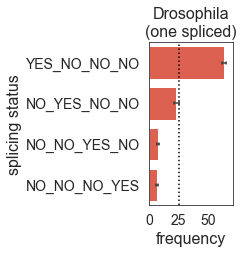

In [170]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Drosophila\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_S2_splicing_order_4int_oneSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [125]:
introns_1yes = S2_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("S2 4 introns, 1 spliced, in order p-value: "+str(p))


S2 4 introns, 1 spliced, in order p-value: 9.451424444531674e-46


In [126]:
introns_1yes = S2_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("S2 4 introns, 1 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 1 spliced YES_NO_NO_NO p-value: 9.451424444531674e-46
S2 4 introns, 1 spliced NO_YES_NO_NO p-value: 0.3954094477586537
S2 4 introns, 1 spliced NO_NO_YES_NO p-value: 1.0674252088178424e-15
S2 4 introns, 1 spliced NO_NO_NO_YES p-value: 5.68614488607017e-17


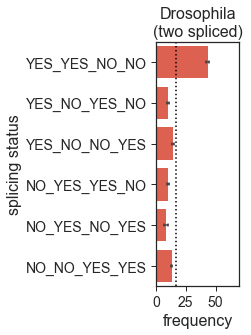

In [22]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=16.67, color='black', linestyle=":")

plt.title("Drosophila\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_S2_splicing_order_4int_twoSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [127]:
introns_2yes = S2_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.166666666667)
print("S2 4 introns, 2 spliced, in order p-value: "+str(p))


S2 4 introns, 2 spliced, in order p-value: 1.4634665420939287e-29


In [128]:
introns_2yes = S2_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.166666666667))

    print("S2 4 introns, 2 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 2 spliced YES_YES_NO_NO p-value: 1.4634665420939287e-29
S2 4 introns, 2 spliced YES_NO_YES_NO p-value: 0.000831677059321049
S2 4 introns, 2 spliced YES_NO_NO_YES p-value: 0.3459307350829994
S2 4 introns, 2 spliced NO_YES_YES_NO p-value: 0.0028755186736463536
S2 4 introns, 2 spliced NO_YES_NO_YES p-value: 3.232297238626853e-05
S2 4 introns, 2 spliced NO_NO_YES_YES p-value: 0.08194634978481727


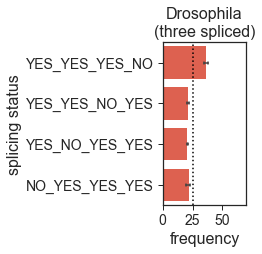

In [23]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Reds")[3]]
sns.barplot(x="percent", y="pattern", data=S2_introns_3yes, palette=fill_colors,
           order=['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction='out', length=5, width=1)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Drosophila\n(three spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_S2_splicing_order_4int_threeSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [131]:
introns_3yes = S2_introns_3yes.copy()

in_order = sum(introns_3yes[(introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(introns_3yes[(introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("S2 4 introns, 3 spliced, in order p-value: "+str(p))


S2 4 introns, 3 spliced, in order p-value: 5.062046922225924e-09


In [132]:
introns_3yes = S2_introns_3yes.copy()
splicing_patterns = ['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_3yes[(introns_3yes['pattern']==i)]['counts']),sum(introns_3yes[(introns_3yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("S2 4 introns, 3 spliced "+i+" p-value: "+str(p))
    

S2 4 introns, 3 spliced YES_YES_YES_NO p-value: 5.062046922225924e-09
S2 4 introns, 3 spliced YES_YES_NO_YES p-value: 0.07064554340343814
S2 4 introns, 3 spliced YES_NO_YES_YES p-value: 0.016587743802366283
S2 4 introns, 3 spliced NO_YES_YES_YES p-value: 0.07064554340343814


In [43]:

exp_in_order = 1/4*np.sum(S2_introns_1yes['counts'])+1/6*np.sum(S2_introns_2yes['counts'])+1/4*np.sum(S2_introns_3yes['counts'])
total = np.sum(S2_introns_1yes['counts'])+np.sum(S2_introns_2yes['counts'])+np.sum(S2_introns_3yes['counts'])

S2_exp_in_order_percent = exp_in_order / total


in_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']=='YES_NO_NO_NO')]['counts']) + sum(S2_introns_2yes[(S2_introns_2yes['pattern']=='YES_YES_NO_NO')]['counts']) + sum(S2_introns_3yes[(S2_introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(S2_introns_1yes[(S2_introns_1yes['pattern']!='YES_NO_NO_NO')]['counts']) + sum(S2_introns_2yes[(S2_introns_2yes['pattern']!='YES_YES_NO_NO')]['counts']) + sum(S2_introns_3yes[(S2_introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=S2_exp_in_order_percent)
print("S2 4 introns, in order p-value: "+str(p))



S2 4 introns, in order p-value: 1.5646978824763114e-65


In [133]:
K562_1_4introns_splicing_patterns, K562_1_pattern_gene_df = get_splicing_pattern_counts(K562_1_multi_introns_df, 4)
K562_2_4introns_splicing_patterns, K562_2_pattern_gene_df = get_splicing_pattern_counts(K562_2_multi_introns_df, 4)
K562_3_4introns_splicing_patterns, K562_3_pattern_gene_df = get_splicing_pattern_counts(K562_3_multi_introns_df, 4)
K562_4_4introns_splicing_patterns, K562_4_pattern_gene_df = get_splicing_pattern_counts(K562_4_multi_introns_df, 4)
K562_5_4introns_splicing_patterns, K562_5_pattern_gene_df = get_splicing_pattern_counts(K562_5_multi_introns_df, 4)

K562_1_4introns_splicing_patterns['rep'] = 'K562_1'
K562_2_4introns_splicing_patterns['rep'] = 'K562_2'
K562_3_4introns_splicing_patterns['rep'] = 'K562_3'
K562_4_4introns_splicing_patterns['rep'] = 'K562_4'
K562_5_4introns_splicing_patterns['rep'] = 'K562_5'

K562_4introns_splicing_patterns = pd.concat([K562_1_4introns_splicing_patterns, K562_2_4introns_splicing_patterns, K562_3_4introns_splicing_patterns, K562_4_4introns_splicing_patterns, K562_5_4introns_splicing_patterns])

K562_pattern_gene = pd.concat([K562_1_pattern_gene_df,K562_2_pattern_gene_df,K562_3_pattern_gene_df,K562_4_pattern_gene_df,K562_5_pattern_gene_df]).reset_index(drop=True)
K562_pattern_gene = K562_pattern_gene[K562_pattern_gene['pattern']!="NO_NO_NO_NO"].reset_index(drop=True)
K562_pattern_gene = K562_pattern_gene[K562_pattern_gene['pattern']!="YES_YES_YES_YES"].reset_index(drop=True)
K562_gene_N = K562_pattern_gene['gene'].nunique()
print("K562 # of genes with reads spanning 4 introns: "+str(K562_gene_N))


K562 # of genes with reads spanning 4 introns: 710


In [134]:
K562_1_introns_1yes, K562_1_introns_2yes, K562_1_introns_3yes = get_intron_splicing_percent(K562_1_4introns_splicing_patterns, 4)
K562_2_introns_1yes, K562_2_introns_2yes, K562_2_introns_3yes = get_intron_splicing_percent(K562_2_4introns_splicing_patterns, 4)
K562_3_introns_1yes, K562_3_introns_2yes, K562_3_introns_3yes = get_intron_splicing_percent(K562_3_4introns_splicing_patterns, 4)
K562_4_introns_1yes, K562_4_introns_2yes, K562_4_introns_3yes = get_intron_splicing_percent(K562_4_4introns_splicing_patterns, 4)
K562_5_introns_1yes, K562_5_introns_2yes, K562_5_introns_3yes = get_intron_splicing_percent(K562_5_4introns_splicing_patterns, 4)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])
K562_introns_3yes = pd.concat([K562_1_introns_3yes, K562_2_introns_3yes, K562_3_introns_3yes, K562_4_introns_3yes, K562_5_introns_3yes])


In [135]:
total_counts = np.sum(K562_introns_1yes['counts'])+np.sum(K562_introns_2yes['counts'])+np.sum(K562_introns_3yes['counts'])
print("K562 # reads spanning 4 introns: "+str(total_counts))


K562 # reads spanning 4 introns: 2268


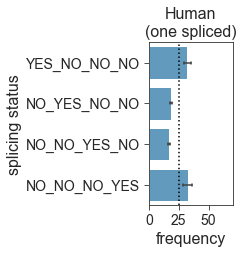

In [38]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Human\n(one spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_K562_splicing_order_4int_oneSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [136]:
introns_1yes = K562_introns_1yes.copy()

in_order = sum(introns_1yes[(introns_1yes['pattern']=='YES_NO_NO_NO')]['counts'])
no_order = sum(introns_1yes[(introns_1yes['pattern']!='YES_NO_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("K562 4 introns, 1 spliced, in order p-value: "+str(p))


K562 4 introns, 1 spliced, in order p-value: 7.71643105588178e-09


In [137]:
introns_1yes = K562_introns_1yes.copy()
splicing_patterns = ['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_1yes[(introns_1yes['pattern']==i)]['counts']),sum(introns_1yes[(introns_1yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("K562 4 introns, 1 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 1 spliced YES_NO_NO_NO p-value: 7.71643105588178e-09
K562 4 introns, 1 spliced NO_YES_NO_NO p-value: 0.00022683515652971754
K562 4 introns, 1 spliced NO_NO_YES_NO p-value: 3.3148526674575326e-07
K562 4 introns, 1 spliced NO_NO_NO_YES p-value: 0.011541821267018158


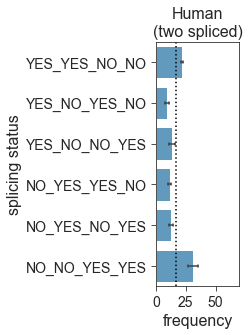

In [37]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=16.67, color='black', linestyle=":")

plt.title("Human\n(two spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_K562_splicing_order_4int_twoSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [138]:
introns_2yes = K562_introns_2yes.copy()

in_order = sum(introns_2yes[(introns_2yes['pattern']=='YES_YES_NO_NO')]['counts'])
no_order = sum(introns_2yes[(introns_2yes['pattern']!='YES_YES_NO_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.166666666667)
print("K562 4 introns, 2 spliced, in order p-value: "+str(p))


K562 4 introns, 2 spliced, in order p-value: 1.4437275038987646e-05


In [139]:
introns_2yes = K562_introns_2yes.copy()
splicing_patterns = ['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_2yes[(introns_2yes['pattern']==i)]['counts']),sum(introns_2yes[(introns_2yes['pattern']!=i)]['counts'])], n=None, p=0.166666666667))

    print("K562 4 introns, 2 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 2 spliced YES_YES_NO_NO p-value: 1.4437275038987646e-05
K562 4 introns, 2 spliced YES_NO_YES_NO p-value: 3.5567011073562477e-06
K562 4 introns, 2 spliced YES_NO_NO_YES p-value: 0.37104769494550427
K562 4 introns, 2 spliced NO_YES_YES_NO p-value: 0.002834466876685522
K562 4 introns, 2 spliced NO_YES_NO_YES p-value: 0.0002785786985316311
K562 4 introns, 2 spliced NO_NO_YES_YES p-value: 6.8786278582669845e-12


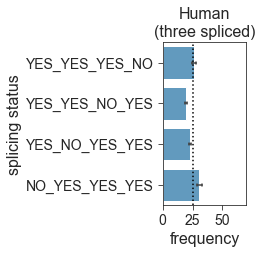

In [36]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_3yes, palette=fill_colors,
           order=['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("Human\n(three spliced)", fontsize=16)

plt.savefig('/path/to/Figure_6B_K562_splicing_order_4int_threeSpliced.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [140]:
introns_3yes = K562_introns_3yes.copy()

in_order = sum(introns_3yes[(introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(introns_3yes[(introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=0.25)
print("K562 4 introns, 3 spliced, in order p-value: "+str(p))


K562 4 introns, 3 spliced, in order p-value: 0.2409949718809941


In [141]:
introns_3yes = K562_introns_3yes.copy()
splicing_patterns = ['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES']

for i in splicing_patterns:

    p = str(stats.binom_test([sum(introns_3yes[(introns_3yes['pattern']==i)]['counts']),sum(introns_3yes[(introns_3yes['pattern']!=i)]['counts'])], n=None, p=0.25))

    print("K562 4 introns, 3 spliced "+i+" p-value: "+str(p))
    

K562 4 introns, 3 spliced YES_YES_YES_NO p-value: 0.2409949718809941
K562 4 introns, 3 spliced YES_YES_NO_YES p-value: 0.0006809583804768347
K562 4 introns, 3 spliced YES_NO_YES_YES p-value: 0.12106896692629468
K562 4 introns, 3 spliced NO_YES_YES_YES p-value: 0.00022349458834229738


In [47]:

exp_in_order = 1/4*np.sum(K562_introns_1yes['counts'])+1/6*np.sum(K562_introns_2yes['counts'])+1/4*np.sum(K562_introns_3yes['counts'])
total = np.sum(K562_introns_1yes['counts'])+np.sum(K562_introns_2yes['counts'])+np.sum(K562_introns_3yes['counts'])

K562_exp_in_order_percent = exp_in_order / total


in_order = sum(K562_introns_1yes[(K562_introns_1yes['pattern']=='YES_NO_NO_NO')]['counts']) + sum(K562_introns_2yes[(K562_introns_2yes['pattern']=='YES_YES_NO_NO')]['counts']) + sum(K562_introns_3yes[(K562_introns_3yes['pattern']=='YES_YES_YES_NO')]['counts'])
no_order = sum(K562_introns_1yes[(K562_introns_1yes['pattern']!='YES_NO_NO_NO')]['counts']) + sum(K562_introns_2yes[(K562_introns_2yes['pattern']!='YES_YES_NO_NO')]['counts']) + sum(K562_introns_3yes[(K562_introns_3yes['pattern']!='YES_YES_YES_NO')]['counts'])

p = stats.binom_test([in_order,no_order], n=None, p=K562_exp_in_order_percent)
print("K562 4 introns, in order p-value: "+str(p))



K562 4 introns, in order p-value: 1.0006186309828583e-10


In [ ]:
### Figure 6C

In [46]:
def get_all_multi_introns(read_junctions, intron_min):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                            temp.append(intron_splice)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df


def get_splicing_patterns(multi_introns_df, total):
    
    splice_status_list = []
    multi_introns_df = multi_introns_df.drop(['read','strand'], 1)

    for i in range(0, len(multi_introns_df)):

        itrons_per_read = sum(multi_introns_df.iloc[i]!='_')

        for j in range(0, itrons_per_read-(total-1)):

            splice_status = multi_introns_df.iloc[i][j:j+total].tolist()

            if (splice_status.count('YES')>0) & (splice_status.count('NO')>0):
                splice_status_list.append(splice_status)

    splicing_patterns_df = pd.DataFrame(splice_status_list)
    
    if (total==3):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3']

    if (total==4):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3','intron 4']

    if (total==5):
        splicing_patterns_df.columns = ['intron 1','intron 2','intron 3','intron 4','intron 5']

    return splicing_patterns_df


def get_intron_quad_order(intron_quads_df):    
    
    intron_quads_order = []

    for i in range(len(intron_quads_df)):
        read =  intron_quads_df.iloc[i]['read']
        strand = intron_quads_df.iloc[i]['strand']
        int1_splice = intron_quads_df.iloc[i]['int1_splice']
        int2_splice = intron_quads_df.iloc[i]['int2_splice']
        int3_splice = intron_quads_df.iloc[i]['int3_splice']
        int4_splice = intron_quads_df.iloc[i]['int4_splice']

        if ((int1_splice == int2_splice) & (int1_splice == int3_splice) & (int1_splice == int4_splice)):
            continue

        else:         
            if (strand == "+"):
                intron_quads_order.append([read, int1_splice, int2_splice, int3_splice, int4_splice])

            elif (strand == "-"):
                intron_quads_order.append([read, int4_splice, int3_splice, int2_splice, int1_splice])

    intron_quads_order_df = pd.DataFrame(intron_quads_order)
    intron_quads_order_df.columns = ['read','intron 1','intron 2','intron 3', 'intron 4']

    intron_quads_plotting_df = intron_quads_order_df.groupby(['intron 1','intron 2','intron 3','intron 4']).size().to_frame('count').reset_index()

    return intron_quads_plotting_df


def get_df_for_plotting_intron_quads(intron_quads_plotting_df):
        
    plot_dict = {'intron 1': [0.0, 0.0, 0.0, 0.0], 'intron 2': [0.0, 0.0, 0.0, 0.0], 'intron 3': [0.0, 0.0, 0.0, 0.0], 'intron 4': [0.0, 0.0, 0.0, 0.0]}
    plot_df = pd.DataFrame(data=plot_dict)
    plot_df.index = ['intron 1','intron 2','intron 3','intron 4']
    
    df = intron_quads_plotting_df
    total = float(np.sum(df['count']))


    for i in range(0,len(plot_df.index)):

        for j in range(0,i):

            row = plot_df.index[i]
            column = plot_df.columns[j]

            plot_df[row][column] = float(np.sum(df[(df[row]=='NO') & (df[column]=='NO')]['count']))/float(total)
        

    for i in range(0,len(plot_df.columns)):

        for j in range(0,i):

            column = plot_df.columns[i]
            row = plot_df.index[j]

            plot_df[row][column] = float(np.sum(df[(df[row]=='YES') & (df[column]=='YES')]['count']))/float(total)
    
   
    return plot_df


def get_df_for_plotting_intron_quads_combined(intron_quads_plotting_df):
        
    plot_dict = {'intron 1': [0.0, 0.0, 0.0, 0.0], 'intron 2': [0.0, 0.0, 0.0, 0.0], 'intron 3': [0.0, 0.0, 0.0, 0.0], 'intron 4': [0.0, 0.0, 0.0, 0.0]}
    plot_df = pd.DataFrame(data=plot_dict)
    plot_df.index = ['intron 1','intron 2','intron 3','intron 4']
    
    df = intron_quads_plotting_df
    total = float(np.sum(df['count']))


    for i in range(0,len(plot_df.columns)):

        for j in range(0,i):

            column = plot_df.columns[i]
            row = plot_df.index[j]

            plot_df[row][column] = float(np.sum(df[df[row]==df[column]]['count']))/float(total)
    
    
    return plot_df
    

In [54]:
# get multi intron df for K562
K562_1_all_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3)
K562_2_all_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3)
K562_3_all_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3)
K562_4_all_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3)
K562_5a_all_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3)
K562_5b_all_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3)
K562_all_multi_introns_df = pd.concat([K562_1_all_multi_introns_df,K562_2_all_multi_introns_df,K562_3_all_multi_introns_df,K562_4_all_multi_introns_df,K562_5a_all_multi_introns_df,K562_5b_all_multi_introns_df],axis=0).reset_index(drop=True)


In [55]:
K562_4introns_splicing = get_splicing_patterns(K562_all_multi_introns_df, 4)

In [56]:
K562_4intron_quad_order = K562_4introns_splicing.groupby(['intron 1','intron 2','intron 3','intron 4']).size().to_frame('count').reset_index()


In [60]:
K562_4intron_combined_plot_df = get_df_for_plotting_intron_quads_combined(K562_4intron_quad_order)

In [61]:
K562_4intron_combined_plot_df

,intron 1,intron 2,intron 3,intron 4
intron 1,0.000000,0.000000,0.000000,0.0
intron 2,0.474868,0.000000,0.000000,0.0
intron 3,0.403439,0.500882,0.000000,0.0
intron 4,0.357584,0.418871,0.522928,0.0


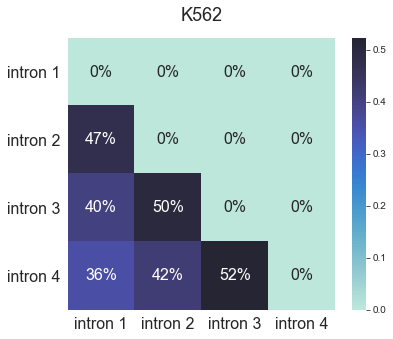

In [62]:
fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(K562_4intron_combined_plot_df, annot=True, center=0.6, annot_kws={"size": 16}, fmt='.0%')

plt.tick_params(axis='both', labelsize=16)
plt.title("K562", fontsize=18, y=1.04)
plt.yticks(rotation=0)

plt.savefig('/path/to/Figure_6C_K562_4int_splicing_order_combined_heatmap.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()